<a href="https://colab.research.google.com/github/Pengyu-gis/RemoteCLIP/blob/main/CLIP_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## gScoreCAM visualization







In [ ]:
#@title CLIP-Loc enviroment setup

#install python 3.9
# !sudo apt-get update -y
# !sudo apt-get install python3.9 python3.9-distutils

# #change alternatives
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

# # install pip for new python
# !wget https://bootstrap.pypa.io/get-pip.py
# !python get-pip.py

# # credit of these last two commands blongs to @Erik
# # install colab's dependencies
# !python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# # link to the old google package
# !ln -s /usr/local/lib/python3.8/dist-packages/google \
#        /usr/local/lib/python3.9/dist-packages/google



# get repo and install env
!git clone https://github.com/anguyen8/gScoreCAM.git
%cd gScoreCAM
!pip install -r colab_requirement.txt
!pip install validators




In [2]:
import os
if "gScoreCAM" not in os.getcwd():
  %cd gScoreCAM/
#@title CLIP-Loc settings
clip_version = "ViT-B/32" #@param ["RN50x16", "RN50x4", "RN50", "RN101", "ViT-B/32", "ViT-B/16", "hila"]
cam_version  = 'gScoreCAM' #@param ['GradCAM', 'ScoreCAM', 'GracCAM++', 'AblationCAM', 'XGradCAM', 'EigenCAM', 'EigengradCAM', 'LayerCAM', 'HilaCAM', 'GroupCAM', 'SSCAM1', 'SSCAM2', 'RawCAM', 'GradientCAM', 'gScoreCAM']
#@title ## Markdown

#@markdown Top-k channels used in gScoreCAM (default=100):
topk_channels = 96 # @param {type:"slider", min:1, max:3072, step:1}
cam_version  = cam_version.lower()
is_transformer = 'vit' in clip_version.lower()

from model_loader.clip_loader import load_clip
from tools.cam import CAMWrapper

clip_model, preprocess, target_layer, cam_trans, clip = load_clip(clip_version)
cam_wrapper = CAMWrapper(clip_model,
                         preprocess=preprocess,
                         target_layers=[target_layer],
                         tokenizer=clip.tokenize,
                         drop=True,
                         cam_version=cam_version,
                         topk=topk_channels,
                         channels=None,
                         is_transformer=is_transformer,
                         cam_trans=cam_trans)

def get_visualization(clip_model, cam_wrapper, img, prompt):
  # encode image and prompt
  raw_size    = img.size
  input_img   = preprocess(img).unsqueeze(0).cuda()
  text_token  = clip.tokenize(prompt).cuda()
  clip_logits = clip_model(input_img.cuda(), text_token.cuda())
  # get cam for prompt and overlay on input image
  cam = cam_wrapper.getCAM(input_img, text_token, raw_size, 0)

  float_img = img_as_float(img)
  if len(float_img.shape) == 2:
      float_img = color.gray2rgb(float_img)
  cam_img   = show_cam_on_image(float_img, cam, use_rgb=True)
  cam_img   = Image.fromarray(cam_img)
  cat_img = Image.new('RGB', (raw_size[0]*2, raw_size[1]))
  cat_img.paste(img, (0,0))
  cat_img.paste(cam_img, (raw_size[0],0))
  score = clip_logits[0].detach().item()
  return cat_img, score

100%|████████████████████████████████████████| 354M/354M [00:02<00:00, 169MiB/s]


100%|██████████| 2/2 [00:00<00:00, 13.54it/s]


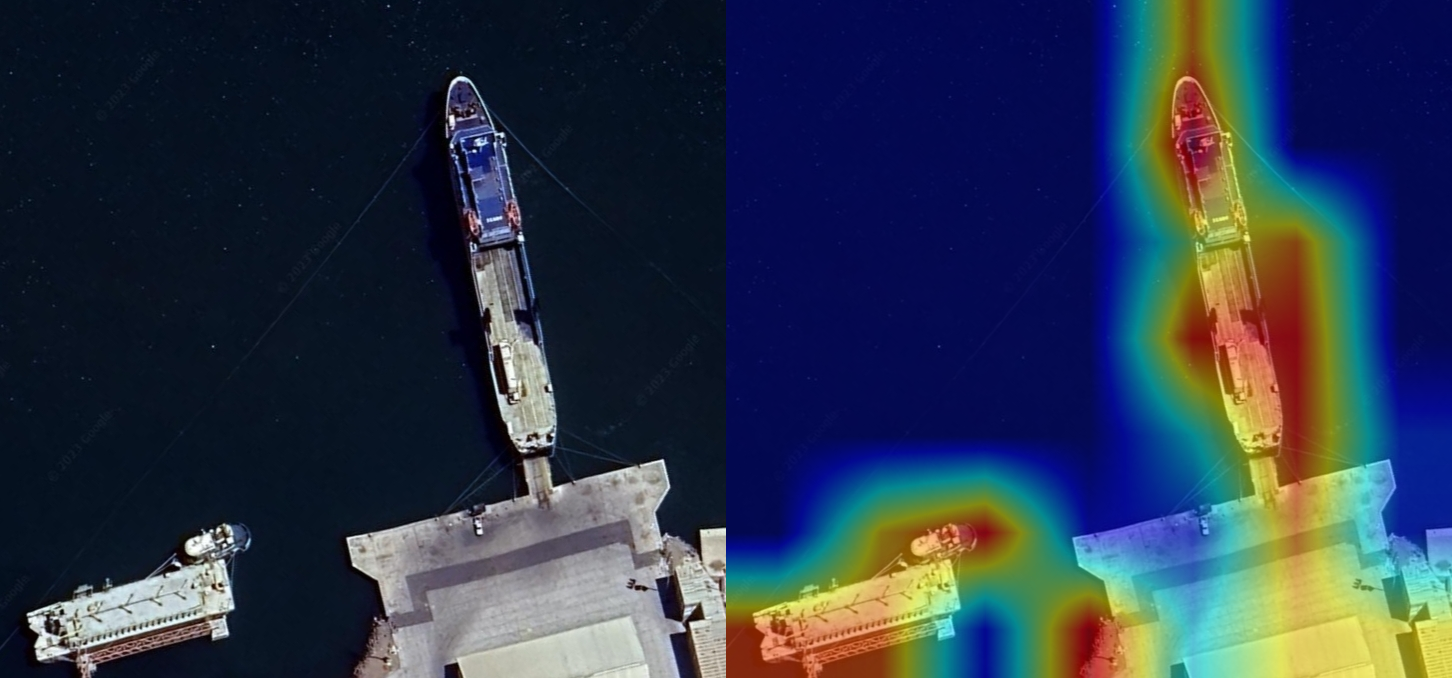

{'CLIP score': 27.25, 'Prompt': 'A freighter ship by the harbor.'}


In [11]:
#@title Play with CLIP
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import requests
import urllib.request
from PIL import Image
from skimage.util import img_as_float
from skimage import color
from pytorch_grad_cam.utils.image import show_cam_on_image
from IPython.display import display
import gc
import torch
import validators
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()# get image
image = "/content/sea_eg.jpg" #@param {type: "string"}
if validators.url(image) == True:
  try:
    urllib.request.urlretrieve(image, "./temp.jgp")
    image = "./temp.jgp"
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image must be a vaild URL.")
else:
  try:
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image is not valid.")
# get prompt
prompt = "A freighter ship by the harbor." #@param {type: "string"}

visualization, score = get_visualization(clip_model, cam_wrapper, img, prompt)

display(visualization)
print({'CLIP score':  score, 'Prompt': prompt})

100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


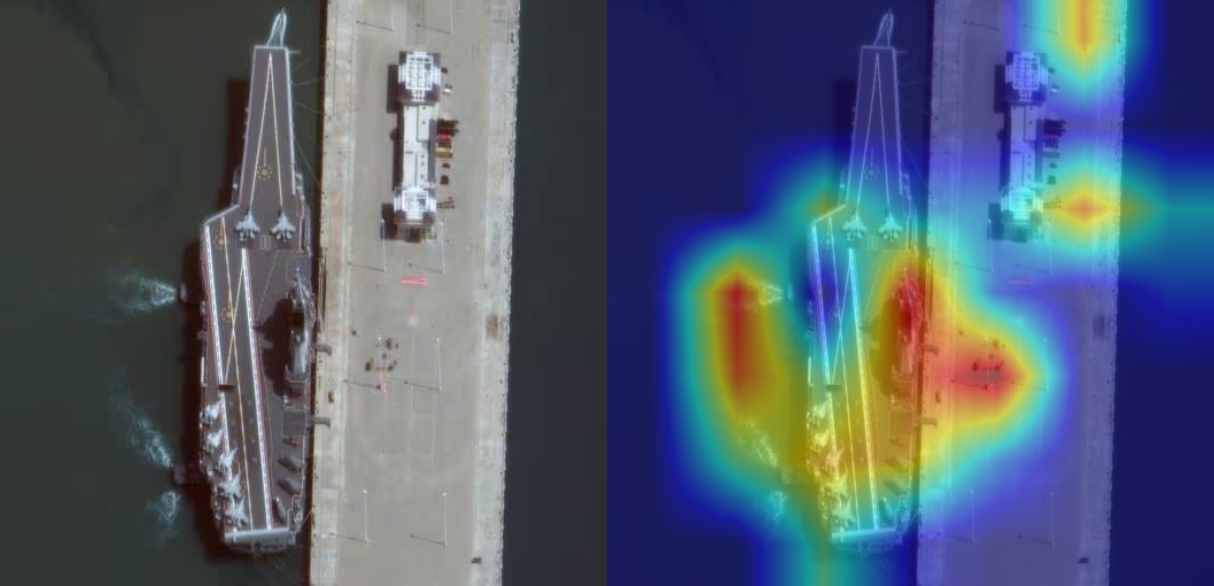

{'CLIP score': 30.390625, 'Prompt': 'aircraft carrier'}


In [18]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()# get image
image = "/content/sea_eg_2.jpg" #@param {type: "string"}
if validators.url(image) == True:
  try:
    urllib.request.urlretrieve(image, "./temp.jgp")
    image = "./temp.jgp"
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image must be a vaild URL.")
else:
  try:
    img = Image.open(image)
  except Exception as e:
    print(e)
    raise Exception("image is not valid.")
# get prompt
prompt = "aircraft carrier" #@param {type: "string"}

visualization, score = get_visualization(clip_model, cam_wrapper, img, prompt)

display(visualization)
print({'CLIP score':  score, 'Prompt': prompt})